# eq_Taux_bias: Zonal structure of time-mean Zonal Mean Stress (Taux) in the equatorial Pacific

Computes the zonal root mean square error (RMSE) of equatorial Pacific (150°E-90°W) climatological (time and meridional 5°S-5°N average) zonal wind stress (Taux) between model and observations

## Datasets Used for Zonal Mean Stress Comparison

The following reference reanalysis datasets are used to evaluate the model simulations:

- **TropFlux (1979-2018)**: The primary dataset for comparison. TropFlux provides estimates of air-sea heat, momentum, and freshwater fluxes over the tropical oceans, designed specifically for tropical climate analysis by combining satellite data and in-situ measurements.

Additional reanalysis datasets used for comparison include:
- **20CRv2 (1871-2012)**: The 20th Century Reanalysis provides global atmospheric data based on surface pressure observations and historical data assimilation, offering a long-term record of climate and weather variability spanning over 140 years.
- **ERA-Interim (1979-2018)**: The European Centre for Medium-Range Weather Forecasts (ECMWF) reanalysis dataset delivers high-resolution atmospheric and surface variables using modern assimilation techniques, often used for climate and weather analysis.
- **NCEP2 (1979-2018)**: The second-generation reanalysis from the National Centers for Environmental Prediction (NCEP), offering improved global atmospheric and surface data by correcting known issues from the earlier version and assimilating more recent observations.

## Dask Cluster 

Start a cluster with multiple cores 

In [2]:
from dask.distributed import Client, progress
client = Client()
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35589 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35589/status,
Dashboard: /proxy/35589/status,Workers: 4
Total threads: 12,Total memory: 95.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46407,Workers: 0
Dashboard: /proxy/35589/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:40463,Total threads: 3
Dashboard: /proxy/43829/status,Memory: 23.75 GiB
Nanny: tcp://127.0.0.1:34753,


## Datasets

In [3]:
from esmvalcore.dataset import Dataset
from esmvalcore.config import CFG
CFG['rootpath']['OBS6'].append(r'/g/data/kj13/datasets/esmvaltool/obsdata-v2') #tier3

In [4]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tauu',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

obs_datasets = {
 "ERA-Interim": 
     Dataset(
     short_name='tauu',
     dataset='ERA-Interim',
     mip="Amon",
     project='OBS6',
     type='reanaly',
     timerange="19790101/20190101",
     tier=3),
# "NOAA-CIRES-20CR-V2": 
#     Dataset(
#     short_name='tauu',
#     dataset='NOAA-CIRES-20CR-V2',
#     mip="Amon",
#     project='OBS6',
#     type='reanaly',
#     timerange="187101/201212",
#     tier=2),
}



## Add Ancillary files

In [5]:
for name, dataset in model_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [6]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

 tauu: attribute positive not present
loaded from file 
(for file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/fx/sftlf/gn/v20191115/sftlf_fx_ACCESS-ESM1-5_historical_r1i1p1f1_gn.nc)


In [7]:
from esmvalcore.preprocessor import annual_statistics
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import axis_statistics
from esmvalcore.preprocessor import mask_landsea

In [8]:
def prepoc1(cube):
    nino3_ep_region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_time(cube, start_year=1979, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)        
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator="mean", period="full")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino3_ep_region)
    cube = axis_statistics(cube, operator="mean", axis="y")
    cube = convert_units(cube, units="1e-3 N/m2")
    return cube

def prepoc2(cube):
    nino3_latext_region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    cube = extract_time(cube, start_year=1979, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)        
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator="mean", period="full")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino3_latext_region)
    cube = convert_units(cube, units="1e-3 N/m2")
    return cube

def prepoc3(cube):
    # nino3_latext_region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    cube = extract_time(cube, start_year=1979, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)        
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator="mean", period="full")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    # cube = extract_region(cube, **nino3_latext_region)
    cube = convert_units(cube, units="1e-3 N/m2")
    return cube

In [9]:
model_datasets_prep1 = {name: prepoc1(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep1 = {name: prepoc1(dataset) for name, dataset in obs_datasets.items()}

model_datasets_prep2 = {name: prepoc2(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep2 = {name: prepoc2(dataset) for name, dataset in obs_datasets.items()}

model_datasets_prep3 = {name: prepoc2(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep3 = {name: prepoc2(dataset) for name, dataset in obs_datasets.items()}

In [9]:
import accessvis
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import os
import pandas as pd
import os
import xarray as xr
import lavavu

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
import cmocean

from tqdm import tqdm
from scipy.ndimage import gaussian_filter

In [10]:
model_data = model_datasets_prep3["ACCESS-ESM1-5"].data

In [11]:
model_datasets_prep2["ACCESS-ESM1-5"]

<iris 'Cube' of surface_downward_eastward_stress / (1e-3 N/m2) (latitude: 30; longitude: 120)>

In [17]:
lv = accessvis.plot_earth(texture='bluemarble', background="white", vertical_exaggeration=20)
lv.rotation(15.0, -150.0, 0.0) #Rotate to Australia
lv.set_properties(diffuse=0.8, ambient=0.1, specular=0.35, shininess=0.03, light=[1,1,0.98]) # make pretty
lv.brightness_contrast_saturation(0.5, 0.5, 0.65)
cmap = plt.get_cmap('coolwarm')
smoothed = gaussian_filter(model_data, sigma=1.0)
colours_model = accessvis.array_to_rgba(smoothed, flip=True, colourmap=cmap, opacitymap=True)
accessvis.update_earth_values(lv, dataMode=0, data=colours_model)

lv.window(resolution=(600,600))

TypeError: '>=' not supported between instances of 'Cube' and 'int'

In [ ]:

data = model_datasets_prep2["ACCESS-ESM1-5"].data  # shape = [lat=30, lon=120]

start_lat, end_lat = -15, 15
start_lon, end_lon = 150, 270

global_lats = np.arange(-90, 90)    # shape = [180]
global_lons = np.arange(0, 360)     # shape = [360]

global_data = np.zeros((len(global_lats), len(global_lons)))

lat_start_idx = np.where(global_lats == start_lat)[0][0]
lat_end_idx = np.where(global_lats == end_lat)[0][0]

lon_start_idx = np.where(global_lons == start_lon)[0][0]
lon_end_idx = np.where(global_lons == end_lon)[0][0]

global_data[lat_start_idx:lat_end_idx, lon_start_idx:lon_end_idx] = data


In [ ]:
global_data.shape

In [ ]:
padded_model_data = np.pad(data, pad_width=((75, 75), (150, 90)), mode='constant', constant_values=0)

In [ ]:
lv = accessvis.plot_earth(texture='bluemarble', background="white", vertical_exaggeration=20)
lv.rotation(15.0, -150.0, 0.0) #Rotate to Australia
lv.set_properties(diffuse=0.8, ambient=0.1, specular=0.35, shininess=0.03, light=[1,1,0.98]) # make pretty
lv.brightness_contrast_saturation(0.5, 0.5, 0.65)
cmap = plt.get_cmap('coolwarm_r')
# smoothed = gaussian_filter(global_data, sigma=1.0)
colours_model = accessvis.array_to_rgba(padded_model_data*-1, flip=True, colourmap=cmap, opacitymap=True)
accessvis.update_earth_values(lv, dataMode=0, data=colours_model)

lv.window(resolution=(600,600))

# Diagnostics Level 1


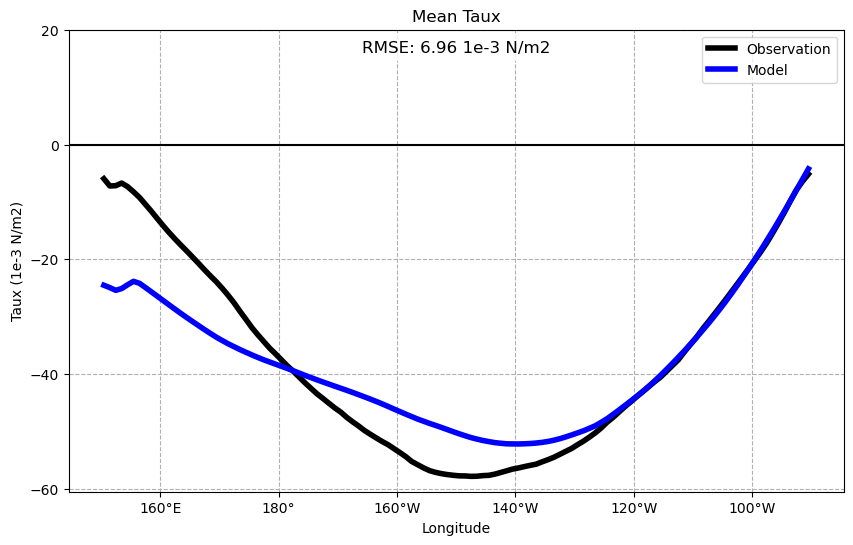

In [9]:
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np

# Function to format x-axis labels with degree symbols and N/S
def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'

plt.figure(figsize=(10, 6))

obs_data = obs_datasets_prep1["ERA-Interim"]
model_data = model_datasets_prep1["ACCESS-ESM1-5"]

# Plot observation data in black
qplt.plot(obs_data, color='black', label='Observation', linewidth=4)

# Plot model data in blue
qplt.plot(model_data, color='blue', label='Model', linewidth=4)

rmse = np.sqrt(np.mean((obs_data.data - model_data.data) ** 2))

# Adding labels and title
plt.xlabel('Longitude')
plt.ylabel('Taux (1e-3 N/m2)')
plt.title('Mean Taux')
plt.grid(linestyle='--')
plt.yticks(np.arange(-60,21, step=20))
plt.axhline(y=0, color='black')

# Adding RMSE text on top of the plot
plt.text(0.5, 0.95, f'RMSE: {rmse:.2f} 1e-3 N/m2', fontsize=12, ha='center', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Setting custom x-axis formatter
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))

# Adding a legend
plt.legend()

# Display the plot
plt.show()

Figure 1: Zonal bias in the structure of zonal wind stress (Taux) across the equatorial Pacific (averaged between 5°S–5°N), primarily highlighting the trade winds bias (typically weaker circulation in the central Pacific and stronger in the western Pacific). The black curve represents the reference data, and the blue curve represents the model data. The metric displayed is the zonal RMSE between the model and reference curves.

# Diagnostics Level 2


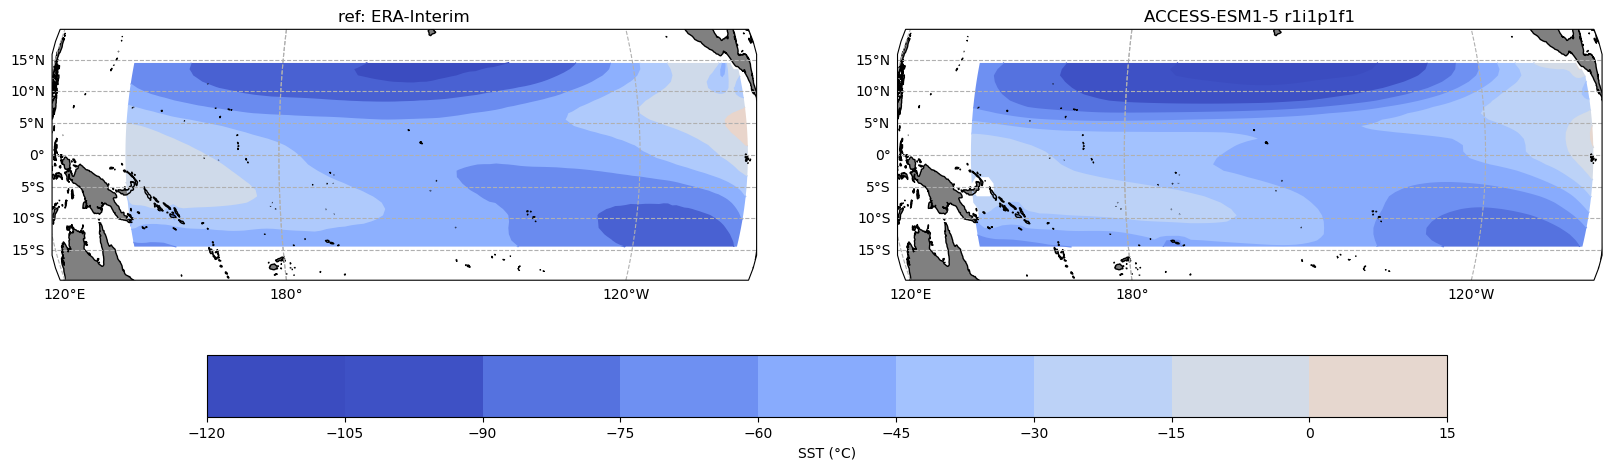

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Importing numpy for linear space creation
import numpy as np

import iris
import iris.plot as iplt

obs_data = obs_datasets_prep2["ERA-Interim"]
model_data = model_datasets_prep2["ACCESS-ESM1-5"]

# Use the coolwarm colormap
cmap = plt.get_cmap('coolwarm')

# Create a large figure
fig = plt.figure(figsize=(20, 10))  # Adjusted for full width

# Center the map on the Pacific Ocean (roughly around 180° longitude)
proj = ccrs.Orthographic(central_longitude=-160, central_latitude=0)

# Define the normalization for the color scale with range of -100 to 100
norm = mcolors.Normalize(vmin=-100, vmax=100)

# Plot #1: contourf with axes longitude from -180 to 180
ax1 = plt.subplot(121, projection=proj)
cf1 = iplt.contourf(obs_data, cmap=cmap, norm=norm)
ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
ax1.coastlines()
ax1.set_extent([120, -80, -20, 20], crs=ccrs.PlateCarree())
ax1.set_title("ref: ERA-Interim")

# Add gridlines for latitude and longitude
gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False

# Plot #2: contourf with axes longitude from 0 to 360
ax2 = plt.subplot(122, projection=proj)
cf2 = iplt.contourf(model_data, cmap=cmap, norm=norm)
ax2.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
ax2.coastlines()
ax2.set_extent([120, -80, -20, 20], crs=ccrs.PlateCarree())
ax2.set_title("ACCESS-ESM1-5 r1i1p1f1")

# Add gridlines for latitude and longitude
gl2 = ax2.gridlines(draw_labels=True, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False

# Add a single colorbar at the bottom
# NOTE: The colorbar will be based on cf2, which already has the correct normalization applied.
cbar = fig.colorbar(cf2, ax=[ax1, ax2], orientation='horizontal', pad=0.15, shrink=0.8)
cbar.set_label('SST (°C)')
# cbar.set_clim(-100, 100)
# cbar.set_ticks(np.linspace(-100, 100, num=11))  # Set ticks ranging from -100 to 100

plt.subplots_adjust(bottom=0.3)  # Further adjust bottom margin to fit the colorbar
plt.show()


Figure 2: Time-mean zonal wind stress (Taux) bias in the equatorial Pacific, illustrating the southeasterly and northeasterly trade winds that form the surface branch of the Walker circulation. The left map shows the reference data, while the right map displays the model data.

In [11]:
# 3d visualization

import accessvis
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import os
import pandas as pd
import os
import xarray as xr
import lavavu

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
import cmocean
from skimage.transform import resize

from tqdm import tqdm
from scipy.ndimage import gaussian_filter

In [12]:
obs_data = obs_datasets_prep2["ERA-Interim"]
model_data = model_datasets_prep2["ACCESS-ESM1-5"]

print(model_data.shape)

def generate_rgba(data, cmap, vmin, vmax):
    data = model_data.data  # 2D numpy array
    lon = model_data.coord('longitude').points
    lat = model_data.coord('latitude').points
    
    lon2d, lat2d = np.meshgrid(lon, lat)
    
    # cmap = cmocean.cm.balance
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    
    fig, ax = plt.subplots(figsize=(6, 3), dpi=100)
    cf = ax.contourf(lon2d, lat2d, data, cmap=cmap, norm=norm, levels=20)
    ax.axis('off')
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

    fig.canvas.draw()
    rgba = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
    rgba = rgba.reshape(fig.canvas.get_width_height()[::-1] + (4,))  # (H, W, 4)

    rgba = rgba[:, :, [1, 2, 3, 0]]
    plt.close(fig)
    return rgba

def resize_rgba(data, width, height):
    #If the original image is of type uint8, it needs to be converted to float32 before resizing.
    rgba_float = rgba.astype(np.float32) / 255.0

    # Resize the image (while preserving the number of channels).
    rgba_resized = resize(rgba_float, (width, height, 4), preserve_range=True, anti_aliasing=True)
    
    # change back to uint8
    rgba_resized = np.clip(rgba_resized * 255, 0, 255).astype(np.uint8)

    return rgba_resized

def pad_rgba(data, pad_width,pad_height,pad_depth=None,constant_values=255):
    if pad_depth:
        padded_rgba = np.pad(
                    data,
                    pad_width=(pad_width, pad_height, pad_depth),
                    mode='constant',
                    constant_values=constant_values
        )
    else:
         padded_rgba = np.pad(
                    data,
                    pad_width=(pad_width, pad_height),
                    mode='constant',
                    constant_values=constant_values 
        )
    return padded_rgba

def normalise_array(values, minimum=None, maximum=None):
    """
    Normalize an array to the range [0,1]

    Parameters
    ----------
    values : numpy.ndarray
        Values to convert, numpy array
    minimum: number
        Use a fixed minimum bound, default is to use the data minimum
    maximum: number
        Use a fixed maximum bound, default is to use the data maximum
    """

    # Ignore nan when getting min/max
    if not minimum:
        minimum = np.nanmin(values)
    if not maximum:
        maximum = np.nanmax(values)

    # Normalise
    array = (values - minimum) / (maximum - minimum)
    # Clip out of [0,1] range - in case defined range is not the global minima/maxima
    array = np.clip(array, 0, 1)

    return array

def opacity_rgba(padded_array, opacity_array):
    array = normalise_array(opacity_array)
    oarray = array
    oarray = np.nan_to_num(oarray)
    oarray = (oarray * 255).astype(np.uint8)
    padded_array[::, ::, 3] = oarray
    return padded_array

(30, 120)


In [16]:
cmap = plt.get_cmap('coolwarm')

rgba=generate_rgba(model_data.data, cmap = cmap, vmin=-120, vmax=15)
resized_rgba=resize_rgba(rgba,width=150,height=600)
padded_rgba=pad_rgba(resized_rgba,pad_width=(375, 375),pad_height=(750, 450),pad_depth=(0, 0))
opacity_array = resize(model_data.data, (150, 600), order=1, preserve_range=True, anti_aliasing=True)
padded_opacity_array=pad_rgba(opacity_array,pad_width=(375, 375),pad_height=(750, 450),constant_values=0)
opacitied_rgba=opacity_rgba(padded_rgba, padded_opacity_array)

lv = accessvis.plot_earth(texture='bluemarble', background="white", vertical_exaggeration=20)
lv.rotation(15.0, -180.0, 0.0) #Rotate to Australia
lv.set_properties(diffuse=0.8, ambient=0.1, specular=0.35, shininess=0.03, light=[1,1,0.98]) # make pretty
lv.brightness_contrast_saturation(0.5, 0.5, 0.65)
accessvis.update_earth_values(lv, dataMode=0, data=opacitied_rgba)

cbar=lv.colourbar(size=[0.95,15], align="bottom", tickvalues=[-105,-90,-75,-60,-45,-30,-15,0])
cbar.colourmap('coolwarm', range=[-120,15])

lv.title("ACCESS-ESM1-5")
lv.window(resolution=(700,700))

In [ ]:
cmap = plt.get_cmap('coolwarm')

rgba=generate_rgba(obs_data.data, cmap = cmap, vmin=-120, vmax=15)
resized_rgba=resize_rgba(rgba,width=150,height=600)
padded_rgba=pad_rgba(resized_rgba,pad_width=(375, 375),pad_height=(750, 450),pad_depth=(0, 0))
opacity_array = resize(model_data.data, (150, 600), order=1, preserve_range=True, anti_aliasing=True)
padded_opacity_array=pad_rgba(opacity_array,pad_width=(375, 375),pad_height=(750, 450),constant_values=0)
opacitied_rgba=opacity_rgba(padded_rgba, padded_opacity_array)

lv = accessvis.plot_earth(texture='bluemarble', background="white", vertical_exaggeration=20)
lv.rotation(15.0, -180.0, 0.0) #Rotate to Australia
lv.set_properties(diffuse=0.8, ambient=0.1, specular=0.35, shininess=0.03, light=[1,1,0.98]) # make pretty
lv.brightness_contrast_saturation(0.5, 0.5, 0.65)
accessvis.update_earth_values(lv, dataMode=0, data=opacitied_rgba)

cbar=lv.colourbar(size=[0.95,15], align="bottom", tickvalues=[-105,-90,-75,-60,-45,-30,-15,0])
cbar.colourmap('coolwarm', range=[-120,15])

lv.title("ACCESS-ESM1-5")
lv.window(resolution=(700,700))